# Ergodicity Basic Simulation - Results Analysis

In [1]:
import re

from pathlib import Path
from PIL import Image

results_dir = Path("results")
pattern = "*Growth Rate*.png"
image_paths = list(results_dir.glob(pattern))

if not image_paths:
    print(f"No PNG files found in {results_dir} matching pattern containing 'Growth Rate'.")
else:
    def natural_key(p):
        # Split into text and number chunks for natural sort
        return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', p.stem)]
    image_paths.sort(key=natural_key)

    frames = []
    for p in image_paths:
        try:
            img = Image.open(p)
            frames.append(img.convert("RGBA"))
        except Exception as e:
            print(f"Skipping {p}: {e}")

    if len(frames) <= 1:
        print("Need at least 2 frames to build an animation.")
    else:
        output_path = results_dir / "Growth Rate Animation.gif"
        frames[0].save(
            output_path,
            save_all=True,
            append_images=frames[1:],
            duration=50,  # ms per frame
            loop=0,        # 0 = infinite loop
            disposal=2
        )
        print(f"Animated GIF saved to: {output_path} ({len(frames)} frames)")

Animated GIF saved to: results\Growth Rate Animation.gif (1125 frames)


In [2]:
import pickle
import re

from pathlib import Path
from PIL import Image

from ergodic_insurance.monte_carlo import SimulationResults

results_dir = Path("results")

pkl_paths = sorted(results_dir.glob("*.pkl"))

all_configurations = {}
if not pkl_paths:
    print(f"No pickle files found in {results_dir}.")
else:
    for path in pkl_paths:
        try:
            with open(path, "rb") as f:
                all_configurations[path.stem] = pickle.load(f)
        except Exception as e:
            print(f"Skipping {path.name}: {e}")
    print(f"Loaded {len(all_configurations)} pickle files into all_configurations.")

Loaded 2315 pickle files into all_configurations.


In [3]:
def get_object_methods(obj):
    """
    Returns a list of all callable methods of a given Python object,
    excluding "dunder" (double underscore) methods.
    """
    methods = []
    for name in dir(obj):
        attribute = getattr(obj, name)
        if callable(attribute) and not name.startswith("__"):
            methods.append(name)
    return methods


one_configuration = all_configurations['Cap (5M) -    ATR (0.5) -    EBITABL (0.1) -    XS_Kurt (4611) -    Ded (0K) -    LR (0.6) -    0K Sims -    50 Yrs']

print("Methods:", get_object_methods(one_configuration))

print("Attributes:", one_configuration.__dict__.keys())

print("Growth Rate:", one_configuration.growth_rates.mean())

print("Risk of Ruin:", one_configuration.ruin_probability)

Methods: ['summary']
Attributes: dict_keys(['final_assets', 'annual_losses', 'insurance_recoveries', 'retained_losses', 'growth_rates', 'ruin_probability', 'metrics', 'convergence', 'execution_time', 'config', 'performance_metrics', 'aggregated_results', 'time_series_aggregation', 'statistical_summary', 'summary_report', 'bootstrap_confidence_intervals'])
Growth Rate: 0.0051223705522716045
Risk of Ruin: {'5': 0.0, '10': 0.0, '15': 0.0, '20': 0.0, '25': 0.0, '30': 0.0, '35': 0.0, '40': 0.0, '45': 0.0, '50': 0.0}


In [4]:
one_configuration.final_assets.shape

(100,)

In [5]:
one_configuration.aggregated_results

{'count': 100,
 'mean': np.float32(6.4595285e+06),
 'std': np.float32(1.0),
 'min': np.float32(6.4595295e+06),
 'max': np.float32(6.4595295e+06),
 'percentiles': {'p1': np.float64(6459529.5),
  'p5': np.float64(6459529.5),
  'p10': np.float64(6459529.5),
  'p25': np.float64(6459529.5),
  'p50': np.float64(6459529.5),
  'p75': np.float64(6459529.5),
  'p90': np.float64(6459529.5),
  'p95': np.float64(6459529.5),
  'p99': np.float64(6459529.5)},
 'moments': {'variance': np.float32(1.0),
  'skewness': np.float32(1.0),
  'kurtosis': np.float32(-2.0),
  'coefficient_variation': np.float32(0.0)}}

In [6]:
print(one_configuration.summary())

Simulation Results Summary
Simulations: 100
Years: 50
Execution Time: 1.77s
Ruin Probability:
  Year 5: 0.00%
  Year 10: 0.00%
  Year 15: 0.00%
  Year 20: 0.00%
  Year 25: 0.00%
  Year 30: 0.00%
  Year 35: 0.00%
  Year 40: 0.00%
  Year 45: 0.00%
  Year 50: 0.00%
Mean Final Assets: $6,459,528
Mean Growth Rate: 0.0051
VaR(99%): $20,534,456
TVaR(99%): $22,318,176
Convergence R-hat: 0.000

Performance Summary
Total Time: 1.77s
Setup: 0.00s
Computation: 1.77s
Serialization: 0.00s (0.0% overhead)
Reduction: 0.00s
Peak Memory: 0.2 MB
CPU Utilization: 0.0%
Throughput: 56 items/s
Speedup: 1.00x

Advanced Aggregation Results:
  p1: $6,459,530
  p5: $6,459,530
  p10: $6,459,530
  p25: $6,459,530
  p50: $6,459,530
  p75: $6,459,530
  p90: $6,459,530
  p95: $6,459,530
  p99: $6,459,530



In [7]:
import pickle
import re

from pathlib import Path
from PIL import Image

from ergodic_insurance.monte_carlo import SimulationResults

def _parse_number(text):
    text = text.strip().replace(",", "")
    m = re.fullmatch(r'([+-]?\d+(?:\.\d+)?)([KMB])?$', text, re.I)
    if not m:
        # fallback: plain int/float or leave as-is
        try:
            return int(text)
        except ValueError:
            try:
                return float(text)
            except ValueError:
                return text
    num = float(m.group(1))
    mult = {"K": 1_000, "M": 1_000_000, "B": 1_000_000_000}.get((m.group(2) or "").upper(), 1)
    val = num * mult
    return int(val) if val.is_integer() else val


def parse_config_key(key: str) -> dict:
    parts = re.split(r"\s*-\s*", key.strip())
    out = {}
    for part in parts:
        if not part:
            continue

        # e.g. "Cap (100M)"
        m = re.match(r"^([A-Za-z_]+)\s*\(\s*([^)]+)\s*\)$", part)
        if m:
            out[m.group(1)] = _parse_number(m.group(2))
            continue

        # e.g. "0K Sims" or "50 Yrs"
        m = re.match(r"^([+-]?\d+(?:\.\d+)?)\s*([KMB])?\s*([A-Za-z_]+)$", part)
        if m:
            value = _parse_number((m.group(1) or "") + (m.group(2) or ""))
            out[m.group(3)] = value
            continue

        # flags like "NOINS"
        if part.upper() == "NOINS":
            out["NOINS"] = True

    return out

results_dir = Path("results")

pkl_paths = sorted(results_dir.glob("*.pkl"))

all_configurations = {}
if not pkl_paths:
    print(f"No pickle files found in {results_dir}.")
else:
    for path in pkl_paths:
        try:
            with open(path, "rb") as f:
                one_config = pickle.load(f)
                growth_rate = one_config.growth_rates.mean()
                ror = one_config.ruin_probability
                all_configurations[path.stem] = {
                    "growth_rate": growth_rate,
                    "risk_of_ruin": ror
                }
        except Exception as e:
            print(f"Skipping {path.name}: {e}")
    print(f"Loaded {len(all_configurations)} pickle files into all_configurations.")

parsed_params_by_key = {k: parse_config_key(k) | all_configurations[k] for k in all_configurations.keys()}
parsed_params_by_key

Loaded 2315 pickle files into all_configurations.


{'Cap (100M) -    ATR (0.5) -    EBITABL (0.1) -    XS_Kurt (10211) -    Ded (50K) -    LR (0.8) -    0K Sims -    50 Yrs': {'Cap': 100000000,
  'ATR': 0.5,
  'EBITABL': 0.1,
  'XS_Kurt': 10211,
  'Ded': 50000,
  'LR': 0.8,
  'Sims': 0,
  'Yrs': 50,
  'growth_rate': np.float64(0.007786552491597831),
  'risk_of_ruin': {'5': 0.0,
   '10': 0.0,
   '15': 0.0,
   '20': 0.0,
   '25': 0.0,
   '30': 0.0,
   '35': 0.0,
   '40': 0.0,
   '45': 0.0,
   '50': 0.0}},
 'Cap (100M) -    ATR (0.5) -    EBITABL (0.1) -    XS_Kurt (10211) -    NOINS -    0K Sims -    50 Yrs': {'Cap': 100000000,
  'ATR': 0.5,
  'EBITABL': 0.1,
  'XS_Kurt': 10211,
  'NOINS': True,
  'Sims': 0,
  'Yrs': 50,
  'growth_rate': np.float64(0.007107467188034206),
  'risk_of_ruin': {'5': 0.0,
   '10': 0.0,
   '15': 0.0,
   '20': 0.0,
   '25': 0.0,
   '30': 0.0,
   '35': 0.0,
   '40': 0.0,
   '45': 0.0,
   '50': 0.0}},
 'Cap (100M) -    ATR (0.5) -    EBITABL (0.1) -    XS_Kurt (15880) -    Ded (0K) -    LR (0.6) -    0K Sims -    

In [8]:
noins_scenarios = {k: v for k, v in parsed_params_by_key.items() if v.get("NOINS")}

C:\Users\alexf\AppData\Local\Temp\ipykernel_29680\2227041254.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("viridis")
C:\Users\alexf\AppData\Local\Temp\ipykernel_29680\2227041254.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


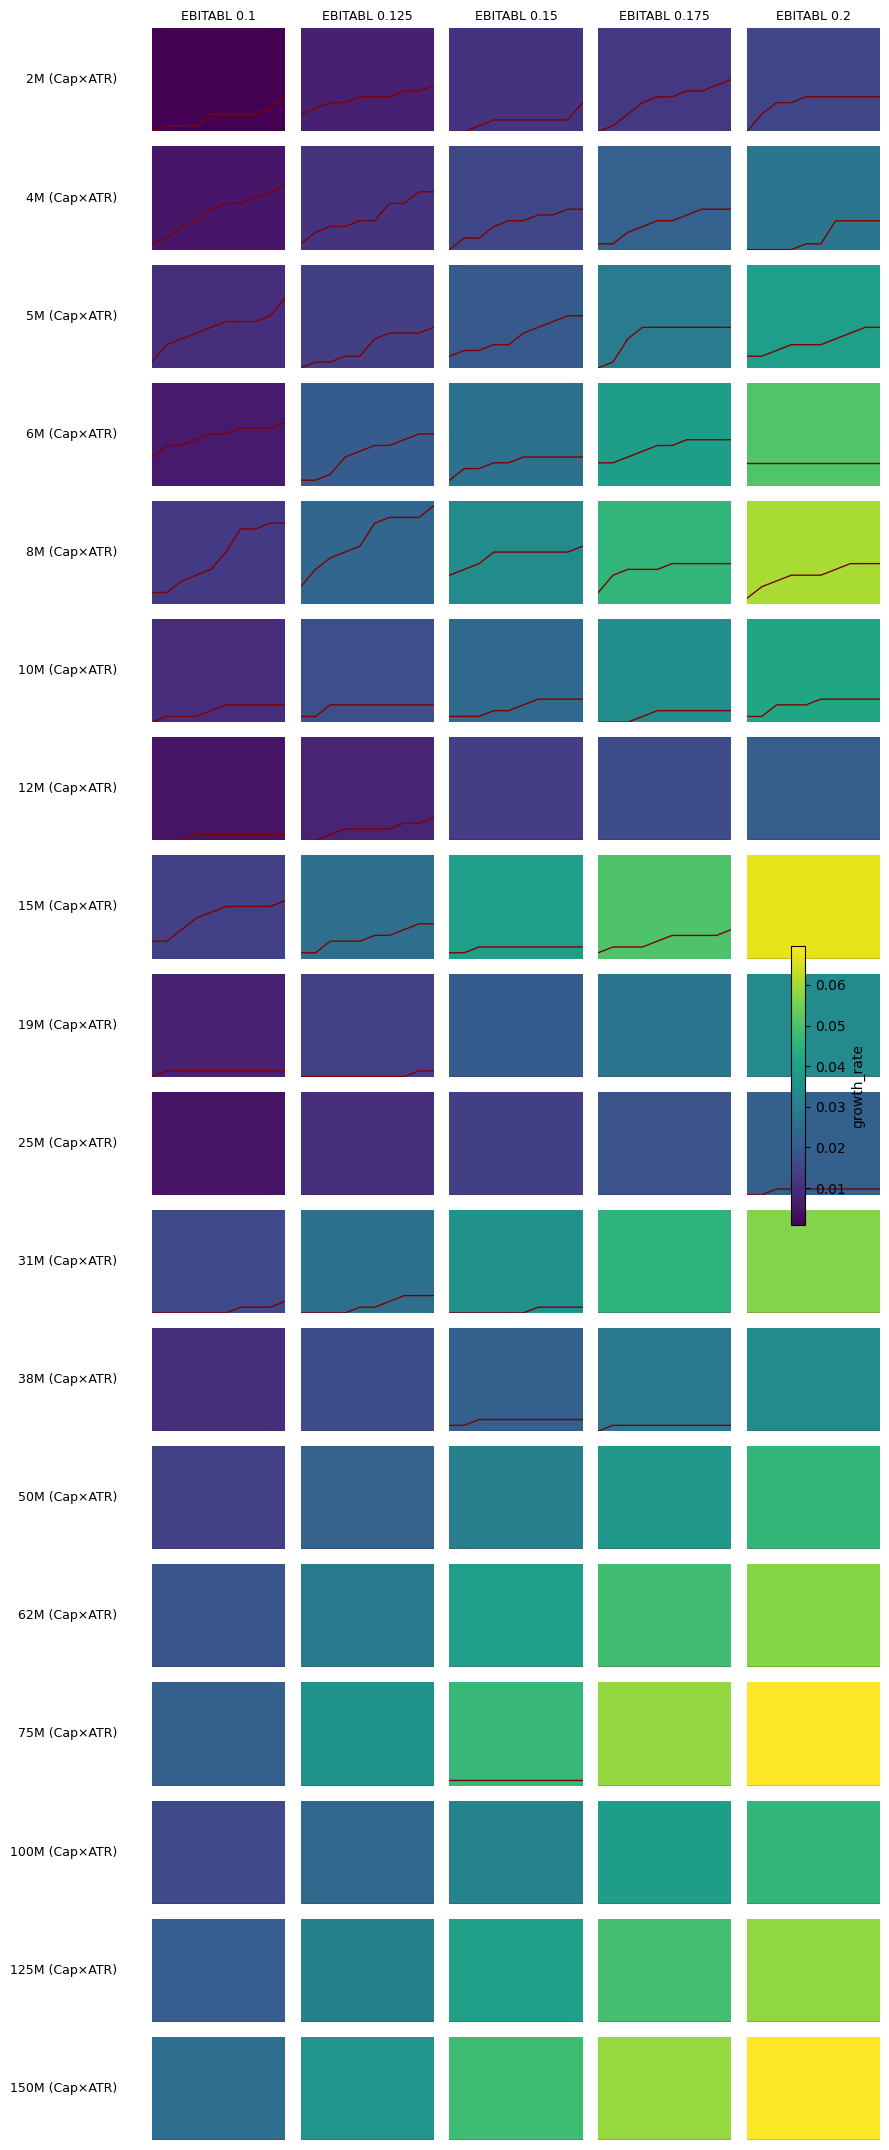

In [9]:
import numpy as np
import matplotlib as mpl

import matplotlib.pyplot as plt

# Collect row/col categories
rows = sorted({v["Cap"] * v["ATR"] for v in noins_scenarios.values()})
cols = sorted({v["EBITABL"] for v in noins_scenarios.values()})

if not rows or not cols:
    print("No data to plot.")
else:
    # Prepare matrices
    gr = np.full((len(rows), len(cols)), np.nan)
    risk_series = [[None for _ in cols] for _ in rows]

    for v in noins_scenarios.values():
        rkey = v["Cap"] * v["ATR"]
        ckey = v["EBITABL"]
        i = rows.index(rkey)
        j = cols.index(ckey)
        gr[i, j] = float(v["growth_rate"])
        ror = v.get("risk_of_ruin", {})
        years = sorted(int(k) for k in ror.keys())
        yvals = [ror[str(k)] for k in years]
        risk_series[i][j] = (years, yvals)

    # Colormap for growth_rate
    vmin, vmax = np.nanmin(gr), np.nanmax(gr)
    cmap = mpl.cm.get_cmap("viridis")
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    # Global y-limit for sparklines
    max_ror = 0.0
    for row in risk_series:
        for item in row:
            if item and item[1]:
                max_ror = max(max_ror, max(item[1]))
    if max_ror == 0:
        max_ror = 1.0

    fig, axes = plt.subplots(len(rows), len(cols), figsize=(max(6, 1.8*len(cols)), max(4, 1.2*len(rows))), squeeze=False)

    for i, rkey in enumerate(rows):
        for j, ckey in enumerate(cols):
            ax = axes[i][j]
            val = gr[i, j]
            ax.set_facecolor(cmap(norm(val)) if not np.isnan(val) else (0.95, 0.95, 0.95, 1.0))

            item = risk_series[i][j]
            if item:
                years, yvals = item
                if years and yvals:
                    ax.plot(years, yvals, color="maroon", lw=1)
                    ax.set_xlim(min(years), max(years))
                    ax.set_ylim(0, max_ror * 1.05)

            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_visible(False)

            if i == 0:
                ax.set_title(f"EBITABL {ckey}", fontsize=9)
        # Row labels on the leftmost cell
        axes[i][0].set_ylabel(f"{rows[i]/1e6:.0f}M (Cap×ATR)", rotation=0, ha="right", va="center", labelpad=25, fontsize=9)

    # Colorbar for growth_rate
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes, fraction=0.02, pad=0.01)
    cbar.set_label("growth_rate")

    plt.tight_layout()
    plt.show()

Animated GIF saved to: results\noins_3d_surface_scatter_ror.gif


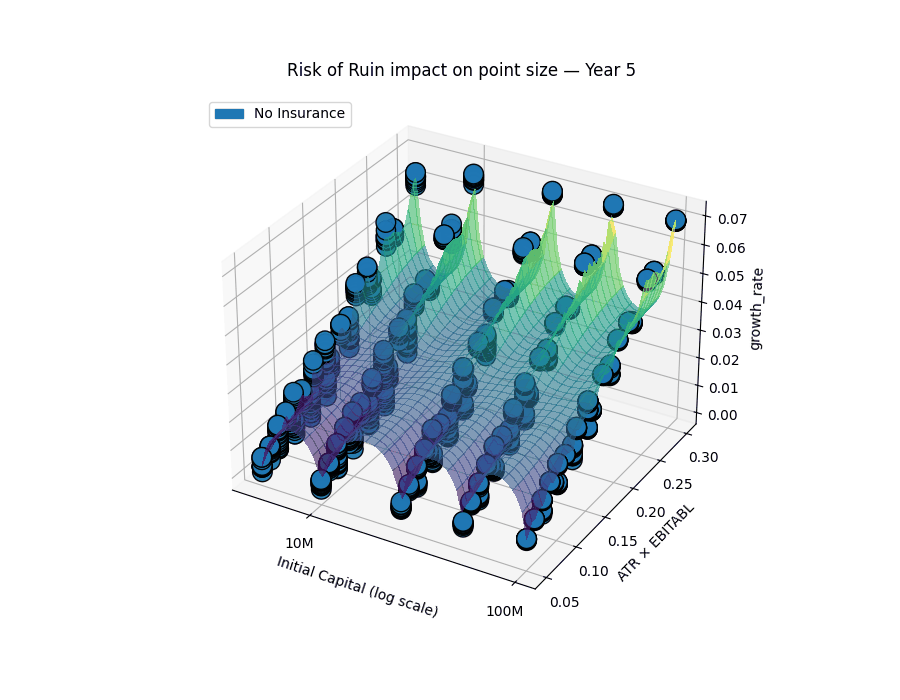

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from pathlib import Path

# Ensure noins_scenarios exists
if not isinstance(globals().get("noins_scenarios"), dict) or not noins_scenarios:
    raise RuntimeError("noins_scenarios is missing or empty. Build it before running this cell.")

# Extract data
scenarios = list(noins_scenarios.values())
N = len(scenarios)

caps = np.array([float(v["Cap"]) for v in scenarios], dtype=float)              # Initial Capital
x_log = np.log10(caps)                                                          # log10 transform for 3D plotting
y_val = np.array([float(v["ATR"]) * float(v["EBITABL"]) for v in scenarios])    # ATR × EBITABL
z_gr = np.array([float(v["growth_rate"]) for v in scenarios], dtype=float)      # growth_rate

# Categories (color by insurance configuration)
cats = np.array([("No Insurance" if v.get("NOINS", False) else "Insurance") for v in scenarios])
uniq_cats = []
colors_map = {}
palette = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray"]
for c in cats:
    if c not in colors_map:
        colors_map[c] = palette[len(colors_map) % len(palette)]
    uniq_cats.append(c)
point_colors = np.array([colors_map[c] for c in cats])

# Gather animation frames based on available 5-year increments
all_years = sorted({int(k) for v in scenarios for k in v.get("risk_of_ruin", {}).keys()})
frame_years = [y for y in all_years if y % 5 == 0] or all_years
if not frame_years:
    raise RuntimeError("No risk_of_ruin years found to animate.")

def clamp01(a):
    a = np.asarray(a, dtype=float)
    return np.nan_to_num(np.clip(a, 0.0, 1.0), nan=1.0)

# Precompute sizes for each frame (s in points^2)
s_min, s_max = 20.0, 200.0
sizes_by_year = []
for yr in frame_years:
    rors = []
    for v in scenarios:
        r = v.get("risk_of_ruin", {}).get(str(yr), np.nan)
        # Accept both fraction (0..1) or percent (0..100)
        if r is None or np.isnan(r):
            rors.append(np.nan)
        else:
            r = float(r)
            if r > 1.0:  # interpret as percent
                r /= 100.0
            rors.append(r)
    rors = np.array(rors, dtype=float)
    inv_risk = clamp01(1.0 - rors)           # higher size when lower risk
    sizes = s_min + inv_risk * (s_max - s_min)
    sizes_by_year.append(sizes)
sizes_by_year = np.stack(sizes_by_year, axis=0)  # (T, N)

# Build an interpolated surface z(x_log, y) via inverse-distance weighting (IDW)
def idw_surface(x, y, z, nx=60, ny=60, power=2.0, eps=1e-12):
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    Xg = np.linspace(xmin, xmax, nx)
    Yg = np.linspace(ymin, ymax, ny)
    XG, YG = np.meshgrid(Xg, Yg)

    # distances to each data point (vectorized)
    dx = XG[..., None] - x[None, None, :]
    dy = YG[..., None] - y[None, None, :]
    dist = np.sqrt(dx*dx + dy*dy) + eps
    w = 1.0 / (dist**power)
    ZG = np.sum(w * z[None, None, :], axis=2) / np.sum(w, axis=2)
    return XG, YG, ZG

# If too few points for a meaningful surface, we fallback to triangulated surface
use_idw = N >= 3
if use_idw:
    XG, YG, ZG = idw_surface(x_log, y_val, z_gr, nx=60, ny=60)
else:
    XG = YG = ZG = None

# Nicely format capital tick labels
def fmt_amount(n):
    n = float(n)
    if n >= 1_000_000_000:
        return f"{n/1_000_000_000:.0f}B"
    if n >= 1_000_000:
        return f"{n/1_000_000:.0f}M"
    if n >= 1_000:
        return f"{n/1_000:.0f}K"
    return f"{n:.0f}"

# Create figure
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

# Plot surface
surf = None
if use_idw:
    surf = ax.plot_surface(XG, YG, ZG, cmap="viridis", alpha=0.6, linewidth=0, antialiased=False)
else:
    # Fallback to triangulation if too few points
    surf = ax.plot_trisurf(x_log, y_val, z_gr, cmap="viridis", alpha=0.6)

# Initial scatter
scat = ax.scatter(x_log, y_val, z_gr, c=point_colors, s=sizes_by_year[0], edgecolor="k", depthshade=True, alpha=0.95)

# Axes labels
ax.set_xlabel("Initial Capital (log scale)")
ax.set_ylabel("ATR × EBITABL")
ax.set_zlabel("growth_rate")

# Set x ticks to show original capital values (log scale)
xmin, xmax = np.min(x_log), np.max(x_log)
xticks = np.arange(np.floor(xmin), np.ceil(xmax) + 1)
xticks = xticks[(xticks >= xmin) & (xticks <= xmax)]
ax.set_xticks(xticks)
ax.set_xticklabels([fmt_amount(10**t) for t in xticks])

# Legend for categories
import matplotlib.patches as mpatches
legend_handles = [mpatches.Patch(color=colors_map[name], label=name) for name in colors_map.keys()]
ax.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(0.02, 0.98))

# Title handle
title = ax.set_title(f"Risk of Ruin impact on point size — Year {frame_years[0]}")

# Anim callbacks
def init():
    scat.set_sizes(sizes_by_year[0])
    title.set_text(f"Risk of Ruin impact on point size — Year {frame_years[0]}")
    return scat, title

def update(frame_idx):
    year = frame_years[frame_idx]
    scat.set_sizes(sizes_by_year[frame_idx])
    title.set_text(f"Risk of Ruin impact on point size — Year {year}")
    return scat, title

anim = FuncAnimation(fig, update, init_func=init, frames=len(frame_years), interval=800, blit=False, repeat=True)

# Save GIF
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)
out_path = results_dir / "noins_3d_surface_scatter_ror.gif"
anim.save(out_path, writer=PillowWriter(fps=1.25))  # ~0.8s per frame
plt.close(fig)

print(f"Animated GIF saved to: {out_path}")

# Inline preview (optional in notebooks)
try:
    from IPython.display import Image, display
    display(Image(filename=str(out_path)))
except Exception:
    pass


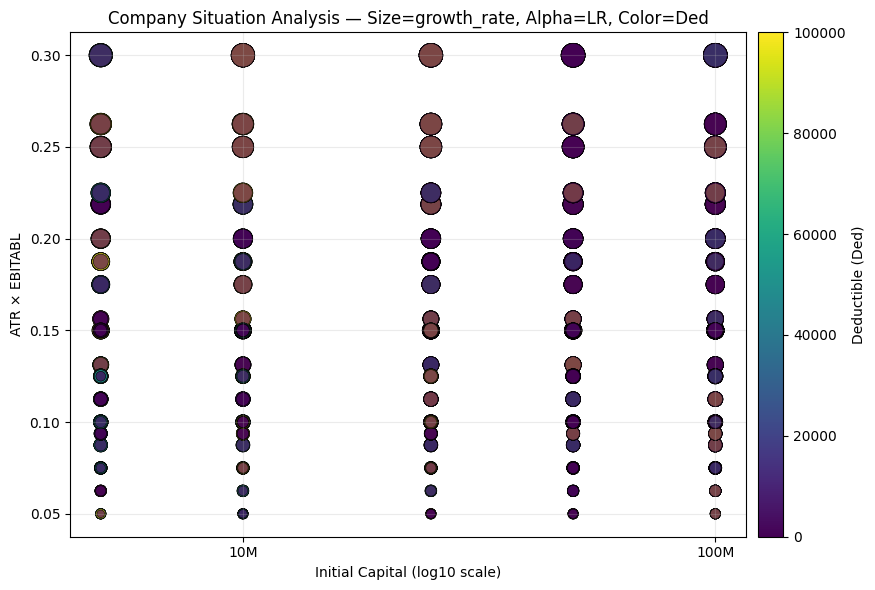

Saved: results\company_situation_scatter.png


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from pathlib import Path

if not isinstance(globals().get("parsed_params_by_key"), dict) or not parsed_params_by_key:
    raise RuntimeError("parsed_params_by_key is missing or empty.")

scenarios = list(parsed_params_by_key.values())

# Extract fields with safe defaults for optional keys
caps   = np.array([float(v.get("Cap", np.nan)) for v in scenarios], dtype=float)
atr    = np.array([float(v.get("ATR", np.nan)) for v in scenarios], dtype=float)
ebit   = np.array([float(v.get("EBITABL", np.nan)) for v in scenarios], dtype=float)
gr     = np.array([float(v.get("growth_rate", np.nan)) for v in scenarios], dtype=float)
lr_raw = np.array([float(v.get("LR", np.nan)) for v in scenarios], dtype=float)
ded    = np.array([float(v.get("Ded", 0.0)) for v in scenarios], dtype=float)

# Drop rows with missing required fields
mask = (~np.isnan(caps)) & (~np.isnan(atr)) & (~np.isnan(ebit)) & (~np.isnan(gr))
caps, atr, ebit, gr, lr_raw, ded = caps[mask], atr[mask], ebit[mask], gr[mask], lr_raw[mask], ded[mask]

# Axes
x = np.log10(caps)               # log of Cap
y = atr * ebit                   # ATR × EBITABL

# Bubble size from growth_rate (linearly normalized)
s_min, s_max = 30.0, 300.0
caps_min, caps_max = np.nanmin(gr), np.nanmax(gr)
if np.isclose(caps_max, caps_min):
    sizes = np.full_like(gr, (s_min + s_max) / 2.0)
else:
    sizes = s_min + (gr - caps_min) / (caps_max - caps_min) * (s_max - s_min)

# Alpha from LR (accept fraction or percent; clamp to [0.3, 1.0] for visibility)
lr = lr_raw.copy()
# Convert percents if needed (heuristic: if any > 1, treat as 0..100)
if np.nanmax(np.where(np.isnan(lr), -np.inf, lr)) > 1.0:
    lr = lr / 100.0
lr = np.nan_to_num(lr, nan=0.5)               # default if missing
lr = np.clip(lr, 0.0, 1.0)
alpha_min, alpha_max = 0.3, 1.0
alphas = alpha_min + lr * (alpha_max - alpha_min)

# Color from Ded using viridis
cmap = plt.cm.viridis
dmin, dmax = float(np.nanmin(ded)), float(np.nanmax(ded))
if np.isclose(dmax, dmin):
    dmin, dmax = dmin - 1.0, dmax + 1.0
norm = mcolors.Normalize(vmin=dmin, vmax=dmax)
colors = cmap(norm(ded))
colors[:, 3] = alphas  # per-point alpha

def fmt_amount(n):
    n = float(n)
    if n >= 1_000_000_000:
        return f"{n/1_000_000_000:.0f}B"
    if n >= 1_000_000:
        return f"{n/1_000_000:.0f}M"
    if n >= 1_000:
        return f"{n/1_000:.0f}K"
    return f"{n:.0f}"

fig, ax = plt.subplots(figsize=(9, 6))
sc = ax.scatter(x, y, c=colors, s=sizes, edgecolor="k", linewidths=0.4)

# X ticks back to original dollars
xmin, xmax = np.min(x), np.max(x)
xticks = np.arange(np.floor(xmin), np.ceil(xmax) + 1)
xticks = xticks[(xticks >= xmin) & (xticks <= xmax)]
ax.set_xticks(xticks)
ax.set_xticklabels([fmt_amount(10**t) for t in xticks])

ax.set_xlabel("Initial Capital (log10 scale)")
ax.set_ylabel("ATR × EBITABL")
ax.set_title("Company Situation Analysis — Size=growth_rate, Alpha=LR, Color=Ded")

# Colorbar for Ded
mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
cbar = plt.colorbar(mappable, ax=ax, pad=0.015)
cbar.set_label("Deductible (Ded)")

ax.grid(True, alpha=0.25)
plt.tight_layout()

# Save and show
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)
out = results_dir / "company_situation_scatter.png"
plt.savefig(out, dpi=150)
plt.show()
print(f"Saved: {out}")


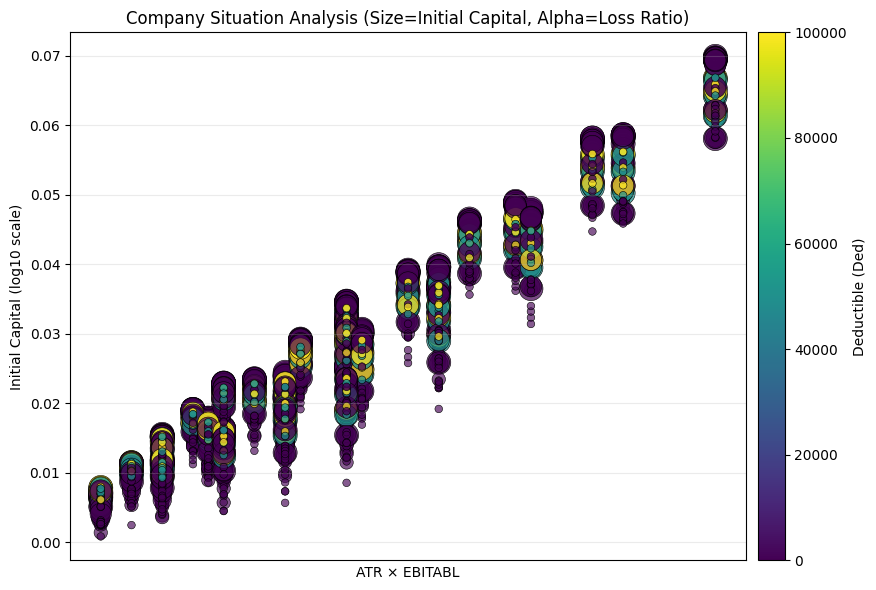

Saved: results\company_situation_scatter_2.png


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from pathlib import Path

if not isinstance(globals().get("parsed_params_by_key"), dict) or not parsed_params_by_key:
    raise RuntimeError("parsed_params_by_key is missing or empty.")

scenarios = list(parsed_params_by_key.values())

# Extract fields with safe defaults for optional keys
caps   = np.array([float(v.get("Cap", np.nan)) for v in scenarios], dtype=float)
atr    = np.array([float(v.get("ATR", np.nan)) for v in scenarios], dtype=float)
ebit   = np.array([float(v.get("EBITABL", np.nan)) for v in scenarios], dtype=float)
gr     = np.array([float(v.get("growth_rate", np.nan)) for v in scenarios], dtype=float)
lr_raw = np.array([float(v.get("LR", np.nan)) for v in scenarios], dtype=float)
ded    = np.array([float(v.get("Ded", 0.0)) for v in scenarios], dtype=float)

# Drop rows with missing required fields
mask = (~np.isnan(caps)) & (~np.isnan(atr)) & (~np.isnan(ebit)) & (~np.isnan(gr))
caps, atr, ebit, gr, lr_raw, ded = caps[mask], atr[mask], ebit[mask], gr[mask], lr_raw[mask], ded[mask]

# Axes
x = atr * ebit       # ATR × EBITABL
y = gr               # growth_rate

# Bubble size from growth_rate (linearly normalized)
s_min, s_max = 30.0, 300.0
caps_log = np.log10(caps)
caps_min, caps_max = np.nanmin(caps_log), np.nanmax(caps_log)
if np.isclose(caps_max, caps_min):
    sizes = np.full_like(caps_log, (s_min + s_max) / 2.0)
else:
    sizes = s_min + (caps_log - caps_min) / (caps_max - caps_min) * (s_max - s_min)

# Alpha from LR (accept fraction or percent; clamp to [0.3, 1.0] for visibility)
lr = lr_raw.copy()
# Convert percents if needed (heuristic: if any > 1, treat as 0..100)
if np.nanmax(np.where(np.isnan(lr), -np.inf, lr)) > 1.0:
    lr = lr / 100.0
lr = np.nan_to_num(lr, nan=0.5)               # default if missing
lr = np.clip(lr, 0.0, 1.0)
alpha_min, alpha_max = 0.3, 1.0
alphas = alpha_min + lr * (alpha_max - alpha_min)

# Color from Ded using viridis
cmap = plt.cm.viridis
dmin, dmax = float(np.nanmin(ded)), float(np.nanmax(ded))
if np.isclose(dmax, dmin):
    dmin, dmax = dmin - 1.0, dmax + 1.0
norm = mcolors.Normalize(vmin=dmin, vmax=dmax)
colors = cmap(norm(ded))
colors[:, 3] = alphas  # per-point alpha

def fmt_amount(n):
    n = float(n)
    if n >= 1_000_000_000:
        return f"{n/1_000_000_000:.0f}B"
    if n >= 1_000_000:
        return f"{n/1_000_000:.0f}M"
    if n >= 1_000:
        return f"{n/1_000:.0f}K"
    return f"{n:.0f}"

fig, ax = plt.subplots(figsize=(9, 6))
sc = ax.scatter(x, y, c=colors, s=sizes, edgecolor="k", linewidths=0.4)

# X ticks back to original dollars
xmin, xmax = np.min(x), np.max(x)
xticks = np.arange(np.floor(xmin), np.ceil(xmax) + 1)
xticks = xticks[(xticks >= xmin) & (xticks <= xmax)]
ax.set_xticks(xticks)
ax.set_xticklabels([fmt_amount(10**t) for t in xticks])

ax.set_xlabel("ATR × EBITABL")
ax.set_ylabel("Growth Rate")
ax.set_ylabel("Initial Capital (log10 scale)")
ax.set_title("Company Situation Analysis (Size=Initial Capital, Alpha=Loss Ratio)")

# Colorbar for Ded
mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
cbar = plt.colorbar(mappable, ax=ax, pad=0.015)
cbar.set_label("Deductible (Ded)")

ax.grid(True, alpha=0.25)
plt.tight_layout()

# Save and show
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)
out = results_dir / "company_situation_scatter_2.png"
plt.savefig(out, dpi=150)
plt.show()
print(f"Saved: {out}")


<Figure size 640x480 with 0 Axes>

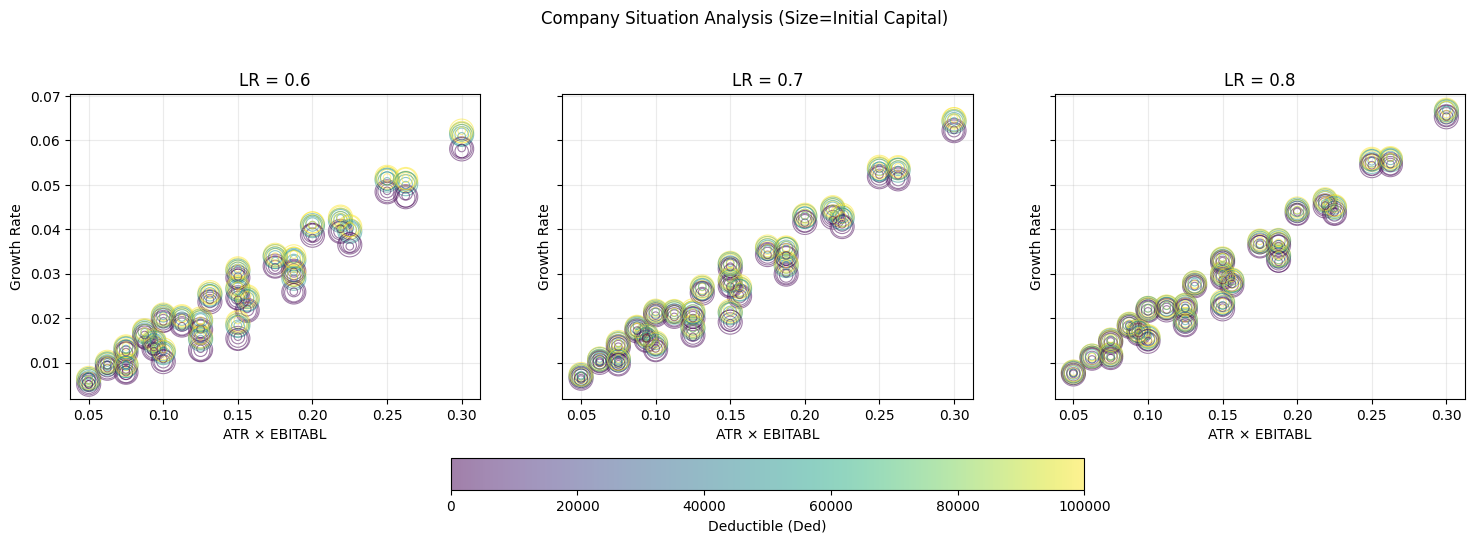

Saved: results\company_situation_scatter_lr_panels.png


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from pathlib import Path

if not isinstance(globals().get("parsed_params_by_key"), dict) or not parsed_params_by_key:
    raise RuntimeError("parsed_params_by_key is missing or empty.")

scenarios = list(parsed_params_by_key.values())

# Extract fields with safe defaults for optional keys
caps   = np.array([float(v.get("Cap", np.nan)) for v in scenarios], dtype=float)
atr    = np.array([float(v.get("ATR", np.nan)) for v in scenarios], dtype=float)
ebit   = np.array([float(v.get("EBITABL", np.nan)) for v in scenarios], dtype=float)
gr     = np.array([float(v.get("growth_rate", np.nan)) for v in scenarios], dtype=float)
lr_raw = np.array([float(v.get("LR", np.nan)) for v in scenarios], dtype=float)
ded    = np.array([float(v.get("Ded", 0.0)) for v in scenarios], dtype=float)

# Drop rows with missing required fields
mask = (~np.isnan(caps)) & (~np.isnan(atr)) & (~np.isnan(ebit)) & (~np.isnan(gr))
caps, atr, ebit, gr, lr_raw, ded = caps[mask], atr[mask], ebit[mask], gr[mask], lr_raw[mask], ded[mask]

# Axes
x = atr * ebit       # ATR × EBITABL
y = gr               # growth_rate

# Bubble size from growth_rate (linearly normalized)
s_min, s_max = 30.0, 300.0
caps_log = np.log10(caps)
caps_min, caps_max = np.nanmin(caps_log), np.nanmax(caps_log)
if np.isclose(caps_max, caps_min):
    sizes = np.full_like(caps_log, (s_min + s_max) / 2.0)
else:
    sizes = s_min + (caps_log - caps_min) / (caps_max - caps_min) * (s_max - s_min)

# Alpha from LR (accept fraction or percent; clamp to [0.3, 1.0] for visibility)
lr = lr_raw.copy()
# Convert percents if needed (heuristic: if any > 1, treat as 0..100)
if np.nanmax(np.where(np.isnan(lr), -np.inf, lr)) > 1.0:
    lr = lr / 100.0
lr = np.nan_to_num(lr, nan=0.5)               # default if missing
lr = np.clip(lr, 0.0, 1.0)
alpha_min, alpha_max = 0.3, 1.0
alphas = alpha_min + lr * (alpha_max - alpha_min)

# Color from Ded using viridis
cmap = plt.cm.viridis
dmin, dmax = float(np.nanmin(ded)), float(np.nanmax(ded))
if np.isclose(dmax, dmin):
    dmin, dmax = dmin - 1.0, dmax + 1.0
norm = mcolors.Normalize(vmin=dmin, vmax=dmax)
colors = cmap(norm(ded))
colors[:, 3] = alphas  # per-point alpha

def fmt_amount(n):
    n = float(n)
    if n >= 1_000_000_000:
        return f"{n/1_000_000_000:.0f}B"
    if n >= 1_000_000:
        return f"{n/1_000_000:.0f}M"
    if n >= 1_000:
        return f"{n/1_000:.0f}K"
    return f"{n:.0f}"

# X ticks back to original dollars
xmin, xmax = np.min(x), np.max(x)
xticks = np.arange(np.floor(xmin), np.ceil(xmax) + 1)
xticks = xticks[(xticks >= xmin) & (xticks <= xmax)]
ax.set_xticks(xticks)
ax.set_xticklabels([fmt_amount(10**t) for t in xticks])

ax.set_xlabel("ATR × EBITABL")
ax.set_ylabel("Growth Rate")
ax.set_ylabel("Initial Capital (log10 scale)")
ax.set_title("Company Situation Analysis (Size=Initial Capital, Alpha=Loss Ratio)")

# Colorbar for Ded
mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
cbar = plt.colorbar(mappable, ax=ax, pad=0.015)
cbar.set_label("Deductible (Ded)")

ax.grid(True, alpha=0.25)
plt.tight_layout()

# Save and show
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)
out = results_dir / "company_situation_scatter_lr.png"
plt.savefig(out, dpi=150)
# Close the single-plot figure and create 3 side-by-side panels by LR
plt.close(fig)

lr_levels = [0.6, 0.7, 0.8]
fig2, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

for ax_i, lvl in zip(axes, lr_levels):
    mask_lvl = np.isclose(lr_raw, lvl, atol=1e-9)
    xi = x[mask_lvl]
    yi = y[mask_lvl]
    si = sizes[mask_lvl]
    ci = cmap(norm(ded[mask_lvl]))
    ci[:, 3] = 0.5  # uniform alpha

    ax_i.scatter(xi, yi, c=ci, s=si)
    ax_i.set_title(f"LR = {lvl}")
    ax_i.set_xlabel("ATR × EBITABL")
    ax_i.set_ylabel("Growth Rate")
    ax_i.grid(True, alpha=0.25)

fig2.suptitle("Company Situation Analysis (Size=Initial Capital)", y=1.02, fontsize=12)

# Leave space at the bottom for the horizontal colorbar
fig2.subplots_adjust(bottom=0.22)

# Transparent (alpha=0) colormap so only circumferences show
hollow_rgba = cmap(np.linspace(0, 1, 256))
hollow_rgba[:, 3] = 0.0  # no fill
hollow_cmap = mcolors.ListedColormap(hollow_rgba, name="hollow_cmap")
mappable = plt.cm.ScalarMappable(norm=norm, cmap=hollow_cmap)
mappable.set_array([])

# Make all scatter markers hollow (no fill) and keep colored outlines
for ax_i in axes:
    for coll in ax_i.collections:
        edge = coll.get_facecolors()
        if edge.size == 0:
            edge = np.array([[0, 0, 0, 1.0]])
        coll.set_edgecolors(edge)
        coll.set_facecolor('none')
        coll.set_linewidths(0.8)

cbar = fig2.colorbar(
    mappable,
    ax=axes.ravel().tolist(),
    orientation="horizontal",
    fraction=0.08,
    pad=0.15,
    alpha=0.5
)
cbar.set_label("Deductible (Ded)")

# Overwrite the saved figure with the updated layout
out = results_dir / "company_situation_scatter_lr_panels.png"
fig2.savefig(out, dpi=150)
plt.show()

print(f"Saved: {out}")


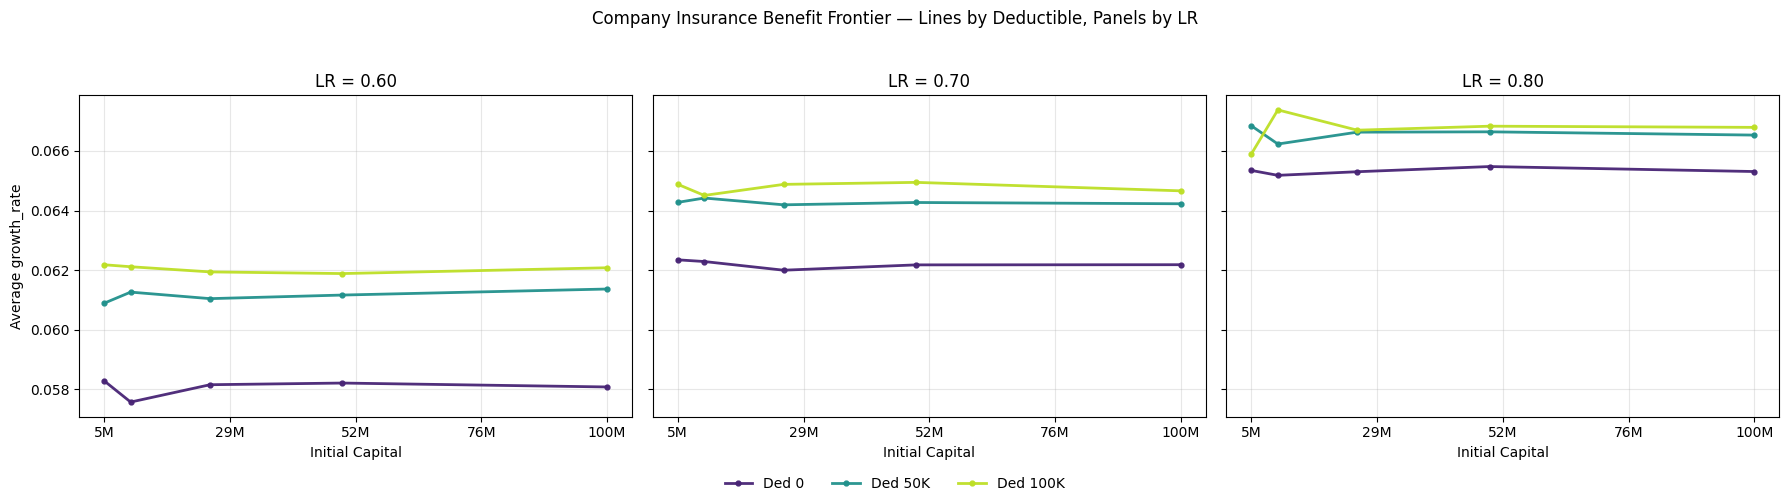

Saved: results\company_insurance_benefit_frontier.png


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

if not isinstance(globals().get("parsed_params_by_key"), dict) or not parsed_params_by_key:
    raise RuntimeError("parsed_params_by_key is missing or empty.")

scenarios = list(parsed_params_by_key.values())

# Extract fields
caps    = np.array([float(v.get("Cap", np.nan))        for v in scenarios], dtype=float)
lr_raw  = np.array([float(v.get("LR", np.nan))         for v in scenarios], dtype=float)
ded     = np.array([float(v.get("Ded", np.nan))        for v in scenarios], dtype=float)
gr      = np.array([float(v.get("growth_rate", np.nan)) for v in scenarios], dtype=float)

# Keep valid rows
mask = (~np.isnan(caps)) & (~np.isnan(lr_raw)) & (~np.isnan(ded)) & (~np.isnan(gr))
caps, lr_raw, ded, gr = caps[mask], lr_raw[mask], ded[mask], gr[mask]

# Normalize LR to fraction if given as percent
lr_frac = lr_raw.copy()
if np.nanmax(np.where(np.isnan(lr_frac), -np.inf, lr_frac)) > 1.0:
    lr_frac = lr_frac / 100.0

# Choose LR panels: prefer 0.6/0.7/0.8 if present; else first three uniques
unique_lr = np.unique(np.round(lr_frac[~np.isnan(lr_frac)], 3))
preferred = [0.6, 0.7, 0.8]
lr_levels = [lvl for lvl in preferred if np.any(np.isclose(unique_lr, lvl, atol=1e-3))]
if len(lr_levels) < 3:
    for u in unique_lr:
        if u not in lr_levels:
            lr_levels.append(float(u))
        if len(lr_levels) == min(3, len(unique_lr)):
            break

# Choose 5 Deductible levels (evenly across sorted uniques)
ded_uni = np.unique(ded[~np.isnan(ded)])
if ded_uni.size == 0:
    raise RuntimeError("No deductible values available.")
if ded_uni.size <= 5:
    ded_levels = ded_uni.tolist()
else:
    idxs = np.round(np.linspace(0, ded_uni.size - 1, 5)).astype(int)
    ded_levels = ded_uni[idxs].tolist()

# Colors for 5 frontiers (viridis)
cmap = plt.cm.viridis
colors = cmap(np.linspace(0.1, 0.9, len(ded_levels)))

def fmt_amount(n):
    n = float(n)
    if n >= 1_000_000_000: return f"{n/1_000_000_000:.0f}B"
    if n >= 1_000_000:     return f"{n/1_000_000:.0f}M"
    if n >= 1_000:         return f"{n/1_000:.0f}K"
    return f"{n:.0f}"

def ded_label(d):
    d = float(d)
    if d >= 1_000_000_000: return f"Ded {d/1_000_000_000:.0f}B"
    if d >= 1_000_000:     return f"Ded {d/1_000_000:.0f}M"
    if d >= 1_000:         return f"Ded {d/1_000:.0f}K"
    return f"Ded {d:.0f}"

# Build frontiers: for each LR pane and Ded level, for each Cap value take max growth_rate
ncols = max(1, len(lr_levels))
fig, axes = plt.subplots(1, ncols, figsize=(6*ncols, 5), sharey=True)
if ncols == 1:
    axes = [axes]

for ax, lvl in zip(axes, lr_levels):
    mask_lr = np.isclose(lr_frac, lvl, atol=1e-3)
    any_plotted = False

    for color, dval in zip(colors, ded_levels):
        mask_ded = np.isclose(ded, dval, rtol=0.0, atol=1e-9)
        m = mask_lr & mask_ded
        if not np.any(m):
            continue

        caps_m = caps[m]
        gr_m = gr[m]

        # Aggregate by Cap: frontier = max growth_rate at each Cap
        unique_caps = np.unique(caps_m)
        if unique_caps.size == 0:
            continue

        xs, ys = [], []
        for c in np.sort(unique_caps):
            vals = gr_m[np.isclose(caps_m, c, atol=1e-9)]
            if vals.size:
                xs.append(c)
                ys.append(np.nanmax(vals))
        if len(xs) < 1:
            continue

        ax.plot(xs, ys, color=color, lw=2.0, marker="o", ms=3.5, label=ded_label(dval), alpha=0.95)
        any_plotted = True

    ax.set_title(f"LR = {lvl:.2f}")
    ax.set_xlabel("Initial Capital")
    ax.grid(True, alpha=0.3)

    # Friendly x tick labels
    if any_plotted:
        xmin, xmax = np.nanmin(caps[mask_lr]), np.nanmax(caps[mask_lr])
        if np.isfinite(xmin) and np.isfinite(xmax) and xmin < xmax:
            # Choose up to ~6 ticks
            ticks = np.linspace(xmin, xmax, num=min(6, int(np.unique(caps[mask_lr]).size)))
            ax.set_xticks(ticks)
            ax.set_xticklabels([fmt_amount(t) for t in ticks], rotation=0)

axes[0].set_ylabel("Average growth_rate")

# Single legend below
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels, loc="lower center", ncol=min(5, len(labels)), frameon=False)
    fig.subplots_adjust(bottom=0.18)

fig.suptitle("Company Insurance Benefit Frontier — Lines by Deductible, Panels by LR", y=0.98, fontsize=12)
fig.tight_layout(rect=[0, 0.05, 1, 0.95])

# Save
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)
out = results_dir / "company_insurance_benefit_frontier.png"
fig.savefig(out, dpi=150)
plt.show()
print(f"Saved: {out}")


In [56]:
list(noins_scenarios.values())[0]

{'Cap': 100000000,
 'ATR': 0.5,
 'EBITABL': 0.1,
 'XS_Kurt': 10211,
 'NOINS': True,
 'Sims': 0,
 'Yrs': 50,
 'growth_rate': np.float64(0.007107467188034206),
 'risk_of_ruin': {'5': 0.0,
  '10': 0.0,
  '15': 0.0,
  '20': 0.0,
  '25': 0.0,
  '30': 0.0,
  '35': 0.0,
  '40': 0.0,
  '45': 0.0,
  '50': 0.0}}

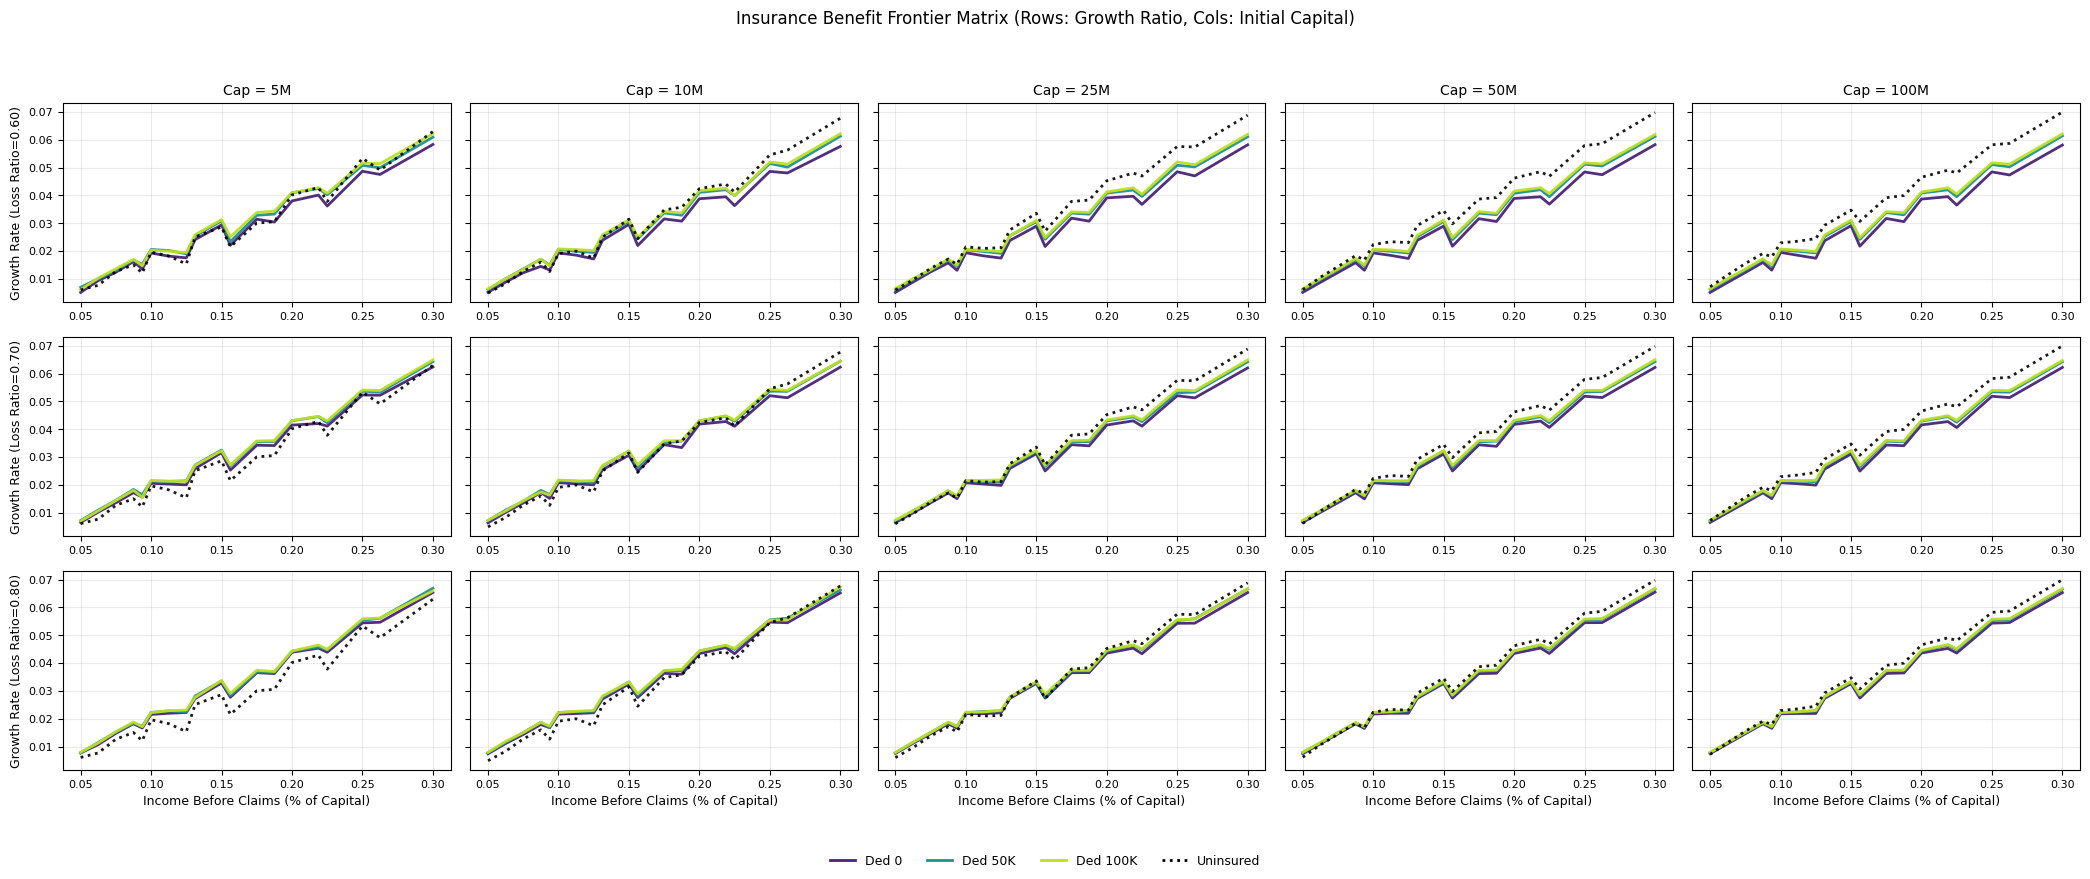

Saved: results\company_insurance_benefit_frontier.png


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path
from collections import defaultdict

all_scens = parsed_params_by_key | noins_scenarios

# Expect parsed_params_by_key built earlier in the notebook
if not isinstance(globals().get("all_scens"), dict) or not all_scens:
    raise RuntimeError("all_scens is missing or empty.")

# Convert scenarios into a normalized list of dicts we can query
def to_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

sc_list = []
for k, v in all_scens.items():
    cap = to_float(v.get("Cap"))
    atr = to_float(v.get("ATR"))
    ebit = to_float(v.get("EBITABL"))
    gr = to_float(v.get("growth_rate"))
    ded = to_float(v.get("Ded"))
    lr_raw = v.get("LR", np.nan)
    lr_f = to_float(lr_raw)
    if np.isfinite(lr_f) and lr_f > 1.0:
        lr_f = lr_f / 100.0  # accept percent
    noins = bool(v.get("NOINS", False))
    xval = atr * ebit if np.isfinite(atr) and np.isfinite(ebit) else np.nan

    # Keep rows where we have basic fields
    if (not np.isfinite(cap)) or (not np.isfinite(gr)) or (not np.isfinite(xval)) \
       or ((not noins) and (not np.isfinite(ded))):
        continue

    sc_list.append({
        "cap": cap,
        "ded": ded,
        "lr": lr_f if np.isfinite(lr_f) else np.nan,
        "noins": noins,
        "x": xval,           # ATR × EBITABL
        "gr": gr
    })

if not sc_list:
    raise RuntimeError("No usable scenarios after filtering.")

# Helper label formatters
def fmt_amount(n):
    n = float(n)
    if n >= 1_000_000_000: return f"{n/1_000_000_000:.0f}B"
    if n >= 1_000_000:     return f"{n/1_000_000:.0f}M"
    if n >= 1_000:         return f"{n/1_000:.0f}K"
    return f"{n:.0f}"

def ded_label(d):
    d = float(d)
    if d >= 1_000_000_000: return f"Ded {d/1_000_000_000:.0f}B"
    if d >= 1_000_000:     return f"Ded {d/1_000_000:.0f}M"
    if d >= 1_000:         return f"Ded {d/1_000:.0f}K"
    return f"Ded {d:.0f}"

# Choose levels: 3 LR rows and 5 Cap columns
ins_rows = [s for s in sc_list if not s["noins"] and np.isfinite(s["lr"])]
if not ins_rows:
    raise RuntimeError("No insurance scenarios with LR available.")

# LR rows: prefer 0.6/0.7/0.8, else first three unique
unique_lr = np.unique(np.round([s["lr"] for s in ins_rows], 3))
preferred_lr = [0.6, 0.7, 0.8]
lr_levels = [lvl for lvl in preferred_lr if np.any(np.isclose(unique_lr, lvl, atol=1e-3))]
if len(lr_levels) < 3:
    for u in unique_lr:
        if not any(np.isclose(u, l, atol=1e-3) for l in lr_levels):
            lr_levels.append(float(u))
        if len(lr_levels) == min(3, unique_lr.size):
            break
if len(lr_levels) == 0:
    raise RuntimeError("Could not determine LR levels.")
nrows = min(3, len(lr_levels))
lr_levels = lr_levels[:nrows]

# Cap columns: pick up to 5 evenly across all caps (ins+noins)
caps_all = sorted(np.unique([s["cap"] for s in sc_list]))
if len(caps_all) == 0:
    raise RuntimeError("No capital values found.")
if len(caps_all) <= 5:
    cap_levels = caps_all
else:
    idxs = np.round(np.linspace(0, len(caps_all) - 1, 5)).astype(int)
    cap_levels = [caps_all[i] for i in idxs]
ncols = min(5, len(cap_levels))
cap_levels = cap_levels[:ncols]

# Deductible lines: up to 5 levels across insurance scenarios
ded_uni = sorted(np.unique([s["ded"] for s in ins_rows]))
if len(ded_uni) <= 5:
    ded_levels = ded_uni
else:
    idxs = np.round(np.linspace(0, len(ded_uni) - 1, 5)).astype(int)
    ded_levels = [ded_uni[i] for i in idxs]

# Colors for deductible frontiers
cmap = plt.cm.viridis
ded_colors = cmap(np.linspace(0.1, 0.9, max(1, len(ded_levels))))

# Frontier aggregator: for a set of (x, y) points, keep max y at each x
def frontier_xy(pairs, round_to=6):
    grp = defaultdict(list)
    for xv, yv in pairs:
        if np.isfinite(xv) and np.isfinite(yv):
            key = float(np.round(xv, round_to))
            grp[key].append(float(yv))
    if not grp:
        return None, None
    xs = np.array(sorted(grp.keys()))
    ys = np.array([np.nanmax(grp[k]) for k in xs])
    return xs, ys

# Build figure
fig, axes = plt.subplots(nrows, ncols, figsize=(4.2*ncols, 2.9*nrows), sharex=False, sharey=True)
if nrows == 1 and ncols == 1:
    axes = np.array([[axes]])
elif nrows == 1:
    axes = np.array([axes])
elif ncols == 1:
    axes = axes[:, np.newaxis]

# Column titles (Cap) and row labels (LR)
for j, cap in enumerate(cap_levels):
    axes[0, j].set_title(f"Cap = {fmt_amount(cap)}", fontsize=10)
for i, lr in enumerate(lr_levels):
    axes[i, 0].set_ylabel(f"Growth Rate (Loss Ratio={lr:.2f})", fontsize=9)

# Plot each panel
for i, lr in enumerate(lr_levels):
    for j, cap in enumerate(cap_levels):
        ax = axes[i, j]

        # Insurance frontiers by deductible at fixed (LR, Cap)
        for color, dval in zip(ded_colors, ded_levels):
            pts = [(s["x"], s["gr"]) for s in sc_list
                   if (not s["noins"])
                   and np.isfinite(s["lr"])
                   and np.isclose(s["lr"], lr, atol=1e-3)
                   and np.isclose(s["cap"], cap, rtol=0.0, atol=1e-9)
                   and np.isclose(s["ded"], dval, rtol=0.0, atol=1e-9)]
            xs, ys = frontier_xy(pts)
            if xs is None:
                continue
            order = np.argsort(xs)
            ax.plot(xs[order], ys[order], color=color, lw=2.0, alpha=0.95, label=ded_label(dval))

        # NOINS baseline for this Cap (same across LR rows)
        pts_noins = [(s["x"], s["gr"]) for s in sc_list
                     if s["noins"] and np.isclose(s["cap"], cap, rtol=0.0, atol=1e-9)]
        xs0, ys0 = frontier_xy(pts_noins)
        if xs0 is not None:
            order0 = np.argsort(xs0)
            ax.plot(xs0[order0], ys0[order0], color="black", lw=2.0, ls="dotted", alpha=0.9, label="Uninsured")

        # Axes cosmetics
        if i == nrows - 1:
            ax.set_xlabel("Income Before Claims (% of Capital)", fontsize=9)
        ax.grid(True, alpha=0.25)
        ax.tick_params(labelsize=8)

# Build a single consolidated legend (ded levels + NOINS) at bottom
legend_elems = [Line2D([0], [0], color=ded_colors[k], lw=2, label=ded_label(ded_levels[k]))
                for k in range(len(ded_levels))]
legend_elems.append(Line2D([0], [0], color="black", lw=2, ls="dotted", label="Uninsured"))

fig.legend(legend_elems, [h.get_label() for h in legend_elems],
           loc="lower center", ncol=min(6, len(legend_elems)), frameon=False, fontsize=9)

fig.suptitle("Insurance Benefit Frontier Matrix (Rows: Growth Ratio, Cols: Initial Capital)",
             y=0.995, fontsize=12)
fig.tight_layout(rect=[0, 0.06, 1, 0.965])

# Save
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)
out = results_dir / "company_insurance_benefit_frontier.png"
fig.savefig(out, dpi=150)
plt.show()
print(f"Saved: {out}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path
from collections import defaultdict

all_scens = parsed_params_by_key | noins_scenarios

# Expect parsed_params_by_key built earlier in the notebook
if not isinstance(globals().get("all_scens"), dict) or not all_scens:
    raise RuntimeError("all_scens is missing or empty.")

# Convert scenarios into a normalized list of dicts we can query
def to_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

sc_list = []
for k, v in all_scens.items():
    cap = to_float(v.get("Cap"))
    atr = to_float(v.get("ATR"))
    ebit = to_float(v.get("EBITABL"))
    gr = to_float(v.get("growth_rate"))
    ded = to_float(v.get("Ded"))
    lr_raw = v.get("LR", np.nan)
    lr_f = to_float(lr_raw)
    if np.isfinite(lr_f) and lr_f > 1.0:
        lr_f = lr_f / 100.0  # accept percent
    noins = bool(v.get("NOINS", False))
    xval = atr * ebit if np.isfinite(atr) and np.isfinite(ebit) else np.nan

    # Keep rows where we have basic fields
    if (not np.isfinite(cap)) or (not np.isfinite(gr)) or (not np.isfinite(xval)) \
       or ((not noins) and (not np.isfinite(ded))):
        continue

    sc_list.append({
        "cap": cap,
        "ded": ded,
        "lr": lr_f if np.isfinite(lr_f) else np.nan,
        "noins": noins,
        "x": xval,           # ATR × EBITABL
        "gr": gr
    })

if not sc_list:
    raise RuntimeError("No usable scenarios after filtering.")

# Helper label formatters
def fmt_amount(n):
    n = float(n)
    if n >= 1_000_000_000: return f"{n/1_000_000_000:.0f}B"
    if n >= 1_000_000:     return f"{n/1_000_000:.0f}M"
    if n >= 1_000:         return f"{n/1_000:.0f}K"
    return f"{n:.0f}"

def ded_label(d):
    d = float(d)
    if d >= 1_000_000_000: return f"Ded {d/1_000_000_000:.0f}B"
    if d >= 1_000_000:     return f"Ded {d/1_000_000:.0f}M"
    if d >= 1_000:         return f"Ded {d/1_000:.0f}K"
    return f"Ded {d:.0f}"

# Choose levels: 3 LR rows and 5 Cap columns
ins_rows = [s for s in sc_list if not s["noins"] and np.isfinite(s["lr"])]
if not ins_rows:
    raise RuntimeError("No insurance scenarios with LR available.")

# LR rows: prefer 0.6/0.7/0.8, else first three unique
unique_lr = np.unique(np.round([s["lr"] for s in ins_rows], 3))
preferred_lr = [0.6, 0.7, 0.8]
lr_levels = [lvl for lvl in preferred_lr if np.any(np.isclose(unique_lr, lvl, atol=1e-3))]
if len(lr_levels) < 3:
    for u in unique_lr:
        if not any(np.isclose(u, l, atol=1e-3) for l in lr_levels):
            lr_levels.append(float(u))
        if len(lr_levels) == min(3, unique_lr.size):
            break
if len(lr_levels) == 0:
    raise RuntimeError("Could not determine LR levels.")
nrows = min(3, len(lr_levels))
lr_levels = lr_levels[:nrows]

# Cap columns: pick up to 5 evenly across all caps (ins+noins)
caps_all = sorted(np.unique([s["cap"] for s in sc_list]))
if len(caps_all) == 0:
    raise RuntimeError("No capital values found.")
if len(caps_all) <= 5:
    cap_levels = caps_all
else:
    idxs = np.round(np.linspace(0, len(caps_all) - 1, 5)).astype(int)
    cap_levels = [caps_all[i] for i in idxs]
ncols = min(5, len(cap_levels))
cap_levels = cap_levels[:ncols]

# Deductible lines: up to 5 levels across insurance scenarios
ded_uni = sorted(np.unique([s["ded"] for s in ins_rows]))
if len(ded_uni) <= 5:
    ded_levels = ded_uni
else:
    idxs = np.round(np.linspace(0, len(ded_uni) - 1, 5)).astype(int)
    ded_levels = [ded_uni[i] for i in idxs]

# Colors for deductible frontiers
cmap = plt.cm.viridis
ded_colors = cmap(np.linspace(0.1, 0.9, max(1, len(ded_levels))))

# Frontier aggregator: for a set of (x, y) points, keep max y at each x
def frontier_xy(pairs, round_to=6):
    grp = defaultdict(list)
    for xv, yv in pairs:
        if np.isfinite(xv) and np.isfinite(yv):
            key = float(np.round(xv, round_to))
            grp[key].append(float(yv))
    if not grp:
        return None, None
    xs = np.array(sorted(grp.keys()))
    ys = np.array([np.nanmax(grp[k]) for k in xs])
    return xs, ys

# Precompute NOINS frontier per Cap at each rounded x (baseline to subtract)
x_round = 6
baseline_by_cap = {}
for cap0 in sorted(np.unique([s["cap"] for s in sc_list])):
    pts_noins_cap = [(s["x"], s["gr"]) for s in sc_list if s["noins"] and np.isclose(s["cap"], cap0, atol=1e-9)]
    xs0, ys0 = frontier_xy(pts_noins_cap, round_to=x_round)
    if xs0 is not None:
        # map rounded-x -> baseline growth
        baseline_by_cap[cap0] = {float(np.round(xr, x_round)): float(y0) for xr, y0 in zip(xs0, ys0)}

# Build figure
fig, axes = plt.subplots(nrows, ncols, figsize=(4.2*ncols, 2.9*nrows), sharex=False, sharey=True)
if nrows == 1 and ncols == 1:
    axes = np.array([[axes]])
elif nrows == 1:
    axes = np.array([axes])
elif ncols == 1:
    axes = axes[:, np.newaxis]

# Column titles (Cap) and row labels (LR)
for j, cap in enumerate(cap_levels):
    axes[0, j].set_title(f"Cap = {fmt_amount(cap)}", fontsize=10)
for i, lr in enumerate(lr_levels):
    axes[i, 0].set_ylabel(f"Growth Lift (LR={lr:.2f})", fontsize=9)

# Plot each panel
for i, lr in enumerate(lr_levels):
    for j, cap in enumerate(cap_levels):
        ax = axes[i, j]

        # Draw zero lift reference line
        ax.axhline(0.0, color="gray", lw=1.0, ls="--", alpha=0.6)

        # Insurance frontiers by deductible at fixed (LR, Cap) — now plot LIFT = insured - NOINS
        base_map = baseline_by_cap.get(cap, {})
        if not base_map:
            # No NOINS baseline for this Cap; skip lift plotting
            continue

        for color, dval in zip(ded_colors, ded_levels):
            pts_ins = [(s["x"], s["gr"]) for s in sc_list
                       if (not s["noins"])
                       and np.isfinite(s["lr"])
                       and np.isclose(s["lr"], lr, atol=1e-3)
                       and np.isclose(s["cap"], cap, rtol=0.0, atol=1e-9)
                       and np.isclose(s["ded"], dval, rtol=0.0, atol=1e-9)]
            xs_ins, ys_ins = frontier_xy(pts_ins, round_to=x_round)
            if xs_ins is None:
                continue

            # Align on rounded x and compute lift
            x_plot, y_lift = [], []
            for xv, yv in zip(xs_ins, ys_ins):
                key = float(np.round(xv, x_round))
                y_base = base_map.get(key, None)
                if y_base is None:
                    continue
                x_plot.append(xv)
                y_lift.append(yv - y_base)

            if not x_plot:
                continue

            order = np.argsort(x_plot)
            ax.plot(np.array(x_plot)[order], np.array(y_lift)[order],
                    color=color, lw=2.0, alpha=0.95, label=ded_label(dval))

        # Axes cosmetics
        if i == nrows - 1:
            ax.set_xlabel("Income Before Claims (% of Capital)", fontsize=9)
        ax.grid(True, alpha=0.25)
        ax.tick_params(labelsize=8)

# Build a single consolidated legend (ded levels only)
legend_elems = [Line2D([0], [0], color=ded_colors[k], lw=2, label=ded_label(ded_levels[k]))
                for k in range(len(ded_levels))]
legend_elems.append(Line2D([0], [0], color="gray", lw=1.0, ls="--", label="Uninsured"))
fig.legend(legend_elems, [h.get_label() for h in legend_elems],
           loc="lower center", ncol=min(6, len(legend_elems)), frameon=False, fontsize=9)

fig.suptitle("Insurance Benefit Frontier Matrix (Rows: Loss Ratio, Cols: Initial Capital)",
             y=0.995, fontsize=12)
fig.tight_layout(rect=[0, 0.06, 1, 0.965])

# Save
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)
out = results_dir / "company_insurance_delta_frontier.png"
fig.savefig(out, dpi=150)
plt.show()
print(f"Saved: {out}")